[View in Colaboratory](https://colab.research.google.com/github/denisparra/pyreclab_tutorial/blob/master/pyreclab_svd_implicit.ipynb)

# Práctica de Sistemas Recomendadores 2: pyreclab - SVD e Implicit Feedback

En este práctico, volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile, para aprender sobre algoritmos más avanzados de recomendación:

* Singular Value Decomposition (SVD)
* Alternating Least Squares (ALS) - Implicit feedback

**Autor**: Antonio Ossa, Manuel Cartagena

**Basado en el material original de**: Denis Parra, Gabriel Sepúlveda

NOMBRE


## Setup

**Paso 1:** Descargue los siguientes tres archivos, siguiendo los links, a su computador local.

* `u2.base`: https://drive.google.com/open?id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA
* `u2.test`: https://drive.google.com/open?id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg
* `u.item`: https://drive.google.com/open?id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz

In [1]:
# Ejecute esta celda. Deberá subir los archivos u2.base, u2.test y u.item
from google.colab import files
uploaded = files.upload()

**Paso 1 (alternativo):** O descargue directamente a Colab los archivos ejecutando las siguientes 3 celdas:

In [2]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--  1077
100 1546k  100 1546k    0     0  1546k      0  0:00:01 --:--:--  0:00:01 1546k


In [27]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--  1672
100  385k  100  385k    0     0   385k      0  0:00:01 --:--:--  0:00:01  385k


In [1]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--   663
100  230k  100  230k    0     0   230k      0  0:00:01 --:--:--  0:00:01 75.1M


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [3]:
#!pip install pandas --upgrade
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade
#!pip install implicit --upgrade

    100% |████████████████████████████████| 153kB 6.8MB/s 


In [0]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
#import implicit
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/), distinta a la que trabajamos en el práctico anterior. Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [21]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [8]:
# Ahora queremos realizar una observación rápida de los datos

df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [0]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())

df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
title                 1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
IMDb_URL              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Children              1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy               1682 non-null int64
Film-Noir             1682 non-null int64
Horror                1682 non-null int64
Musical               1682 non-null int64
Mystery               1682 non-null int64
Romance               1682 non-null int64
Sci-Fi                1682 non-null int64
Thriller              1682 non-null int64
War      

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  cat_pos = np.ones(swarm_data.size) * center


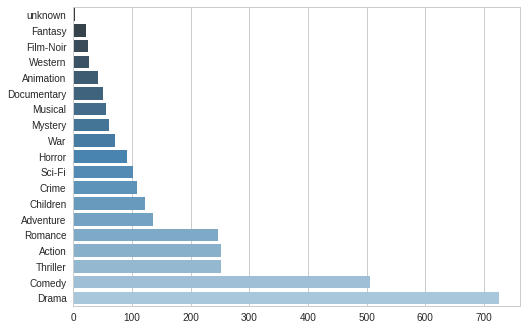

In [13]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** COMPLETAR

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [22]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [0]:
# Definicion de objeto svd

svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [28]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7202097999263785
RMSE: 0.9146481987731379


In [29]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.10405406768321078
NDCG@20: 0.06646553689847878


In [26]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 318, 1367, 64, 408, 1512, 169, 1467, 480, 1558, 483, 320, 12, 963, 174, 134, 1639, 923, 187, 1642]


In [33]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
480,North by Northwest (1959),01-Jan-1959,NaN,http://us.imdb.com/M/title-exact?North%20by%20...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

y describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió:

**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [34]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7204724640279949, 0.7205483800993591, 0.7206007656437508]
[0.9129415513513617, 0.9130101793355441, 0.9130902255937667]


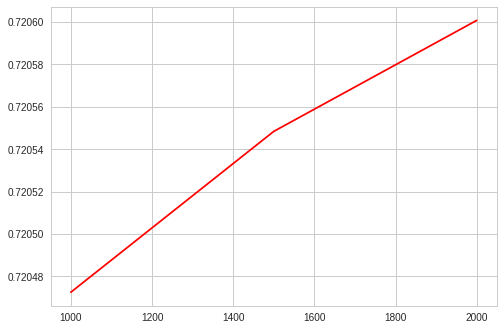

In [35]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

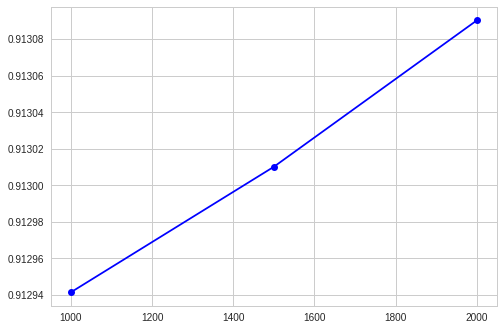

In [36]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

In [0]:
# Pruebe con otros valores y/o parámetros:



## ALS (Implicit Feedback)

In [30]:
%%time
# Definicion del objeto recomendador als
alscg = pyreclab.IFAlsConjugateGradient(dataset='u2.base',
                     dlmchar=b'\t',
                     header=False,
                     usercol=0,
                     itemcol=1,
                     observationcol=2)

CPU times: user 270 ms, sys: 17 ms, total: 287 ms
Wall time: 286 ms


In [39]:
%%time
# Entrenamiento del modelo
alscg.train(factors=120, alsNumIter=10, lambd=0.001, cgNumIter=3)

CPU times: user 1min 10s, sys: 8.98 ms, total: 1min 10s
Wall time: 1min 10s


Calcular métricas contra un dataset de testing

In [40]:
%%time
# Testing de recomendaciones en el dataset de testx
top_n = 20

recommendList, maprec, ndcg = alscg.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.0023481368128592532
NDCG@20: 0.0004825032342004251
CPU times: user 1.73 s, sys: 8.01 ms, total: 1.74 s
Wall time: 1.74 s


Listar recomendaciones para un usuario en particular

In [41]:
%%time
# Calcular las recomendaciones para el usuario escogido
user_id = 10
ranking = [int(r) for r in alscg.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 10: [871, 1028, 25, 270, 323, 480, 429, 898, 671, 926]
CPU times: user 3.27 ms, sys: 3 µs, total: 3.27 ms
Wall time: 4.15 ms


In [0]:
# Ver explicitamente las recomendaciones para el usuario
df_items.loc[ranking]

Pruebe distintos valores de los parámetros de entrenamiento del algoritmo ALS:
- Número de factores
- Número de iteraciones
- Lambda

y describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió:



```
# Tiene formato de código
```

